# Input Importance Explained

Click [here](https://github.com/kxytechnologies/kxy-python/blob/master/docs/latest/notebooks/classification/input_importance/index.ipynb) to download this page as a Jupyter Notebook.

In the Getting Started section, we briefly illustrated how pre-learning and post-learning classification problems can be solved using the `kxy` package. 

In this case study we do a deep-dive into **input importance**, and illustrate that the analysis provided by the `kxy` package makes intuitive sense on the bank note UCI classification dataset.

First we define the requied imports, and load the dataset.

In [1]:
import os
# os.environ['KXY_API_KEY'] = 'YOUR API KEY GOES HERE'
import pandas as pd
import kxy

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00267/' \
    'data_banknote_authentication.txt'
df = pd.read_csv(url, names=['Variance', 'Skewness', 'Kurtosis', 'Entropy', 'Is Fake'])

Next, we normalize the data so that each input takes value in $[0, 1]$, so as to ease visualization. All input importance analyses performed by the `kxy` package are robust to increasing transformations, including the foregoing normalization. Nonetheless, we will take a copy of the data before normalization, which we will use for analyses, the normalized data being used only for visualization.

In [3]:
ef = df.copy() # Copy used for analysis.
# Normalization to ease vizualization
df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']] = \
    (df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']] - \
     df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']].min(axis=0))
df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']] /= \
    df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']].max(axis=0)

## Individual Input Importance

### Intuition

We begin by forming an intuition for what we would expect out of an individual input importance analysis.

We recall that **individual input importance analysis** aims at quantifying the usefulness of each input for predicting the output, when used in isolation.

Intuitively, saying that an input $x_i$ is informative about a categorical label $y$ in isolation is the same as saying that observing the value of $x_i$ is useful for inferring the value of the label/class $y$. For this to be true, it ought to be the case that the collection of values of $x_i$ corresponding to a given class or value of $y$, should be sufficiently different from the collections of values of $x_i$ corresponding to the other classes. 

The more these collections are *different*, the less ambiguity there will be in inferring $y$ from $x_i$, and therefore the more useful $x_i$ will be for inferring $y$ in isolation (i.e. the higher its individual input importance score should be).

In the case of the bank note dataset, for every one of the four inputs of interest, we plot all values on the same line, and color each point red or green depending on whether the observed input came from a fake note or not. The more distinguishable the collection of red ticks is from the collection of green ticks, the more the corresponding input is useful at predicting whether or not a bank note is a forgery.

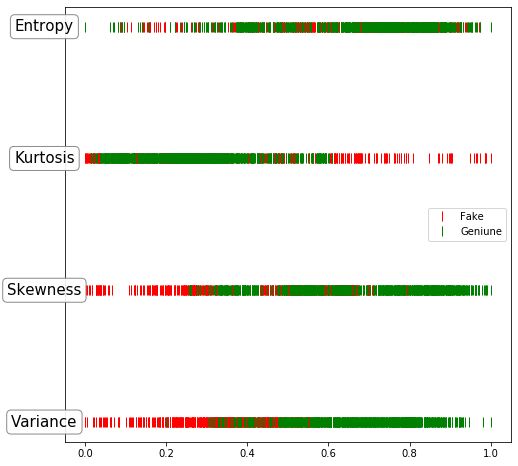

In [4]:
import pylab as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

y = df['Is Fake'].values.astype(bool)
v = df['Variance'].values
s = df['Skewness'].values
k = df['Kurtosis'].values
e = df['Entropy'].values

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.plot(v[y], 0.0*np.ones_like(v[y]), '|', color='r', linewidth=2, markersize=10,\
        label='Fake')
ax.plot(v[~y], 0.0*np.ones_like(v[~y]), '|', color='g', linewidth=2, markersize=10,\
        label='Geniune')
ax.text(-0.1, 0, "Variance", ha="center", va="center", size=15, bbox=bbox_props)
ax.plot(s[y], 0.1*np.ones_like(s[y]), '|', color='r', linewidth=2, markersize=10)
ax.plot(s[~y], 0.1*np.ones_like(s[~y]), '|', color='g', linewidth=2, markersize=10)
ax.text(-0.1, 0.1, "Skewness", ha="center", va="center", size=15, bbox=bbox_props)
ax.plot(k[y], 0.2*np.ones_like(k[y]), '|', color='r', linewidth=2, markersize=10)
ax.plot(k[~y], 0.2*np.ones_like(k[~y]), '|', color='g', linewidth=2, markersize=10)
ax.text(-0.1, 0.2, "Kurtosis", ha="center", va="center", size=15, bbox=bbox_props)
ax.plot(e[y], 0.3*np.ones_like(e[y]), '|', color='r', linewidth=2, markersize=10)
ax.plot(e[~y], 0.3*np.ones_like(e[~y]), '|', color='g', linewidth=2, markersize=10)
ax.text(-0.1, 0.3, "Entropy", ha="center", va="center", size=15, bbox=bbox_props)
ax.axes.yaxis.set_visible(False)
plt.legend()
plt.show()

In [5]:
'Percentage of points with a normalized kurtosis higher than 0.6: %.2f%%' %\
    (100.*(df['Kurtosis'] > 0.6).mean())

'Percentage of points with a normalized kurtosis higher than 0.6: 7.43%'

Clearly, from the plot above, it is visually very hard to differenciate geniune bank notes from forgeries solely using the `Entropy` input. As for the `Kurtosis` variable, while a normalized kurtosis higher than 0.6 is a strong indication that the bank note is a forgery, this only happens about 7% of the time. When the normalized kurtosis is lower than 0.6 on the other hand, it is very hard to distinguish geniune notes from forgeries using the kurtosis alone. The `Skewness` input is visually more useful than the previously mentioned two inputs, but the `Variance` input is clearly the most useful. Geniune bank notes tend to have a higher variance, and forgeries tend to have a lower variance.

### Validation 

Let's see if the individual input importance analysis of the `kxy` package is consistent with these observations.

In [6]:
ef.kxy.individual_input_importance('Is Fake').round(2)\
    .rename(columns={'input': 'Input', \
        'individual_importance': 'Individual Importance',\
        'normalized_individual_importance': 'Normalized Individual Importance',\
        'cum_normalized_individual_importance': \
    'Cummulative Normalized Individual Importance'})

,Input,Individual Importance,Normalized Individual Importance,Cummulative Normalized Individual Importance
0,Variance,1.31,0.72,0.72
1,Skewness,0.42,0.23,0.95
2,Kurtosis,0.09,0.05,1.00
3,Entropy,0.00,0.00,1.00


Both the ranking and the magnitudes of individual input importance scores calculated by the `kxy` package are indeed consistent with our crude visual analysis.

## Incremental Input Importance

### Intuition

Moving on to **incremental input importance**, the objective of this analysis is to quantify the marginal usefulness of each input for predicting the label. Specifically, we are no longer exclusively interested in determining how good inputs can be when used in isolation to predict the label, but rather in studying what happens when some inputs are used together. Of particular interest is the ability to detect inputs that are redundant and inputs that are complementary.

Redundant inputs should be avoided, as they might result in *overfitting* during the training phase, either as a result of ill-conditioning (e.g. the effect of linearly dependent inputs in linear regression), or as a result of the model complexity of the classifier used increasing as a function of the number of inputs (i.e. adding redundant inputs could artificially increase model complexity for the same effective number of inputs, to the point of overfitting). On the other hand, an input that is complementary to other inputs could shed some light where said inputs are not sufficiently informative to accurately predict the label.

Let's try to form an intuitive understanding of the marginal usefulness of our four inputs for predicting whether a bank note is a forgery. As the previous analysis suggested, clearly `Variance` is the input with the highest usefulness when used in isolation. 

To figure out which of the three remaining inputs would complement `Variance` the best, we make three 2D scatter plots with `Variance` as the x-axis and the other input as the y-axis and, as always, we color dots green (resp. red) when the associated inputs came from a geniune (resp. fake) bank note. Intuitively, the input that complements `Variance` the best is the one where the collections of green and red points are the most distinguishable. The more distinguishable these two collections, the more accurate it would be to predict whether the bank note is a forgery. The more the two collections overlap, the more ambiguous our prediction will be.

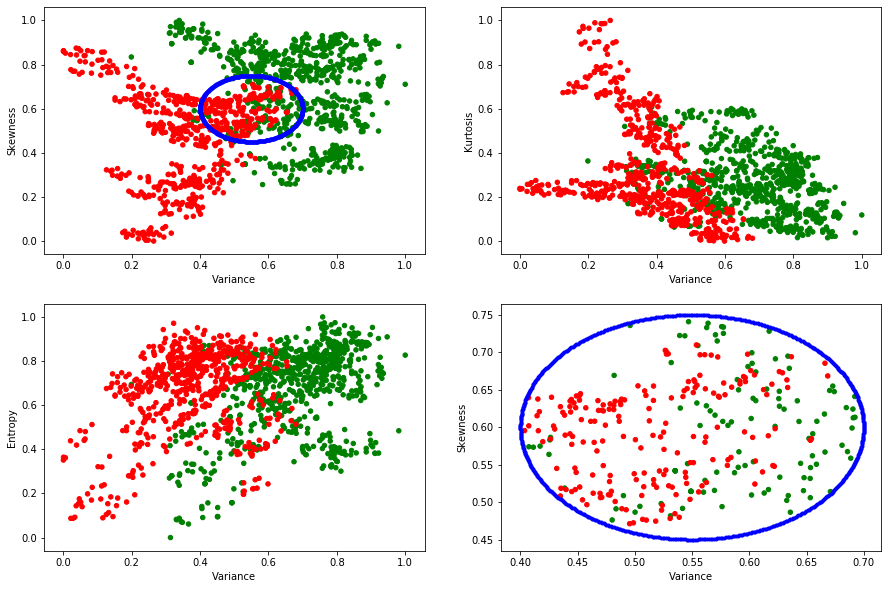

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
df.plot.scatter(ax=ax[0, 0], x='Variance', y='Skewness', c=df['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
df.plot.scatter(ax=ax[0, 1], x='Variance', y='Kurtosis', c=df['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
df.plot.scatter(ax=ax[1, 0], x='Variance', y='Entropy', c=df['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
theta = np.arange(0, 2*np.pi, 0.01)
bound_x = 0.55 + 0.15*np.cos(theta)
bound_y = 0.6 + 0.15*np.sin(theta)
ax[0, 0].plot(bound_x, bound_y, '.', c='b')

selector = (((df['Variance']-0.55)/0.15)**2 + ((df['Skewness']-0.6)/0.15)**2) <=1
cf = df[selector]
cf.plot.scatter(ax=ax[1, 1], x='Variance', y='Skewness', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
ax[1, 1].plot(bound_x, bound_y, '.', c='b')
plt.show()

As it can be seen above, it is in the plot `Variance` x `Skewness` that the collections of green and red points overlap the least. Thus, one would conclude that `Skewness` is the input that should be expected to complement `Variance` the most.

To qualitatively determine which of `Entropy` or `Kurtosis` would complement the pair (`Variance`, `Skewness`) the most, we identity values of the pair (`Variance`, `Skewness`) that are jointly inconclusive about whether the bank note is a forgery. This is the region of the `Variance` x `Skewness` plane where green dots and red dots overlap. We have crudely idendified this region in the top-left plot with the blue ellipse, a zoomed-in version thereof is displayed in the bottom right plot. 

We then seek to know which of `Entropy` and `Kurtosis` can best help alleviate the ambiguity inherent to that region. To do so, we consider all the bank notes that fall within the blue ellipse above, and we plot them on the four planes `Variance` x `Kurtosis`, `Variance` x `Entropy`, `Skewness` x `Kurtosis`, and `Skewness` x `Entropy`, in an attempt to figure out how much ambiguity we can remove at a glance by knowing `Entropy` or `Kurtosis`.

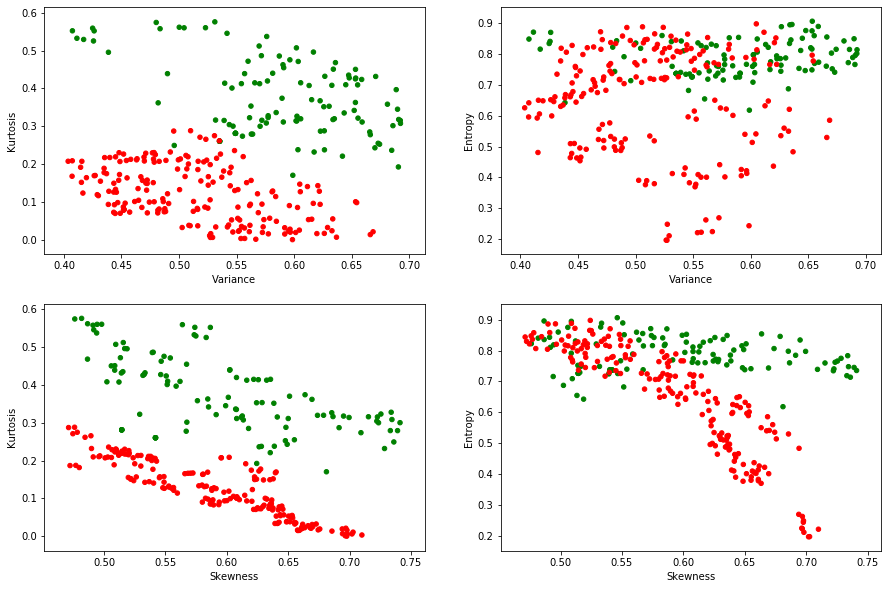

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
cf.plot.scatter(ax=ax[0, 0], x='Variance', y='Kurtosis', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
cf.plot.scatter(ax=ax[0, 1], x='Variance', y='Entropy', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
cf.plot.scatter(ax=ax[1, 0], x='Skewness', y='Kurtosis', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
cf.plot.scatter(ax=ax[1, 1], x='Skewness', y='Entropy', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
plt.show()

As it turns out, knowing the value of the input `Kurtosis` allows us to almost perfectly differentiate geniune notes from forgeries, among all notes that were previously ambiguous to tell apart solely using `Variance` and `Skewness`. On the other hand, although it helps alleviate some ambiguity, the input `Entropy` appears not as effective as `Kurtosis`.

Thus, the third input in decreasing order of marginal usefulness is expected to be `Kurtosis`, `Entropy` being the least marginally useful.



### Validation

Let's see if the incremental input importance analysis of the `kxy` package is consistent with these observations.

In [9]:
ef.kxy.incremental_input_importance('Is Fake').round(2)\
    .rename(columns={'input': 'Input', 'selection_order': 'Selection Order', \
        'incremental_importance': 'Incremental Importance',\
        'normalized_incremental_importance': 'Normalized Incremental Importance',\
        'cum_normalized_incremental_importance': \
    'Cummulative Normalized Incremental Importance'})

,Input,Selection Order,Incremental Importance,Normalized Incremental Importance,Cummulative Normalized Incremental Importance
0,Variance,1,1.31,0.56,0.56
1,Skewness,2,0.46,0.19,0.75
2,Kurtosis,3,0.39,0.17,0.92
3,Entropy,4,0.18,0.08,1.00


The `kxy` package selected inputs in the same order as our qualitative analysis, and the relative magnitudes of marginal usefulness scores (`Incremental Importance`) seem consistent with the impact we would expect each input to have on reducing ambiguity in each stage of our qualitative analysis above. 